### Cluster Problem

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import pandas as pd
from collections import Counter

### Data Preparation

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

,x,y,color
0,0.129270,1.979720,red
1,-0.380831,1.693519,red
2,0.718693,1.791793,red
3,0.722922,0.620655,red
4,-0.432689,0.541550,red


In [24]:
X_test = data.iloc[:, 0:-1]


In [3]:
data.color.unique()

array(['red', 'blue', 'green', 'teal', 'orange', 'purple'], dtype=object)

<AxesSubplot:xlabel='x', ylabel='y'>

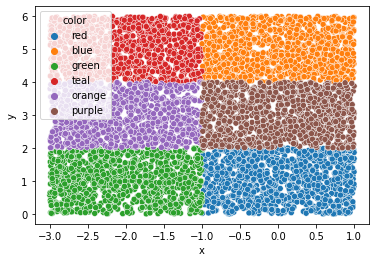

In [4]:
sns.scatterplot(data=data, hue='color', x='x', y='y')

> This time around we are making predictions on multiple colors

In [5]:
class Colors(Dataset):
    def __init__(self,path, transform=None, shuffle=False):
        self.path = path
        self.transform = transform
        self.dataFrame = pd.read_csv(path)
        self.xy = pd.read_csv(path).values
        self.shuffle = shuffle
        
        if self.shuffle:
            np.random.shuffle(self.xy)
            
        self.x = self.xy[:, :2]
        self.y_cate = self.xy [:, -1]
        self.colors_dict = dict([(value, key) for (key, value) in enumerate(['red', 'blue', 'green', 'teal', 'orange', 'purple'])])
#         self.y_values = np.array([self.colors_dict[i] for i in self.y_cate])
        self.y = np.array([self.colors_dict[i] for i in self.y_cate]) #np.array([np.eye(6)[i] for i in self.y_values])
        self.len = self.y.shape[0]
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def plot(self):
        sns.scatterplot(data=self.dataFrame, x='x', y='y',hue='color')
        plt.show()

In [6]:
np.eye(6)[0]

array([1., 0., 0., 0., 0., 0.])

### Transformers

In [7]:
class ToTensor:
    def __call__(self, samples):
        x, y = samples
        return torch.from_numpy(x.astype('float32')) ,torch.from_numpy(np.array(y)).long()

In [8]:
train = Colors(
    'data/train.csv',
    transform =ToTensor(),
    shuffle=True
)
test = Colors(
    'data/test.csv',
    ToTensor(),
    shuffle=True
)

In [9]:
train[:9]

(tensor([[-1.5644,  4.6182],
         [-2.1949,  0.8624],
         [-2.3254,  1.3529],
         [ 0.5560,  0.8773],
         [ 0.8866,  0.7024],
         [-0.4735,  3.5952],
         [-1.9657,  2.6672],
         [-0.2656,  5.3361],
         [ 0.4013,  0.1302]]),
 tensor([3, 2, 2, 0, 0, 5, 4, 1, 0]))

> Train plot

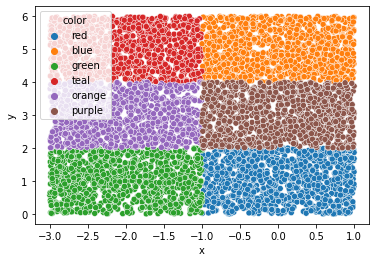

In [10]:
train.plot()

> Test plot

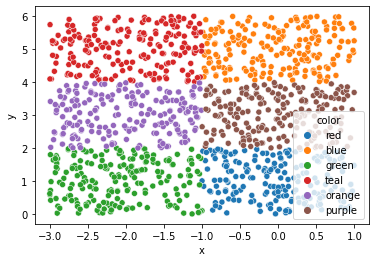

In [11]:
test.plot()

### Data Loading

In [12]:
train_set = DataLoader(dataset=train,
                      batch_size =10,
                      shuffle=True)
test_set = DataLoader(dataset=test,
                      batch_size =10,
                      shuffle=False)

In [18]:
for j, k in train_set:
    pass

In [20]:
len(j)

10

### Model

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 6)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
net

Net(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=6, bias=True)
)

In [26]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [40]:
def accuracy(y_pred, y_true):
    total = 0
    correct = 0
    y_pred_ = torch.argmax(y_pred, dim=1)
    for i in range(len(y_true)):
        if y_pred_[i] == y_true[i]:
            correct +=1
        total +=1
    return correct/total
    

In [45]:
EPOCHS = 30
for epoch in range(EPOCHS):
    y_true = None
    y_pred = None
    for X, y  in train_set:
        optimizer.zero_grad()
        # forward pass 
        outputs = net(X)
        #loss calc
        y_true = y
        y_pred = outputs
        
        loss = criterion(outputs, y)
        # backward pass
        loss.backward()
        # update the weights
        optimizer.step() 
    if (epoch + 1) % 10 == 0:
        accu = accuracy(y_pred, y_true)
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f"loss: {loss.item():.3f}, accuracy: {accu:.3f}")

Epoch 10/30
loss: 0.002, accuracy: 1.000
Epoch 20/30
loss: 0.001, accuracy: 1.000
Epoch 30/30
loss: 0.004, accuracy: 1.000


### Evaluating the model on the Test Data

In [51]:
total = 0
correct = 0
with torch.no_grad():
    for data in test_set:
        X, y = data
        output = torch.argmax(net(X), dim=1)
        for i in range(len(y)):
            if output[i] == y[i]:
                correct +=1
            total+=1
    print("Accuracy: ", correct/total)

Accuracy:  0.9916666666666667


### Making predictions

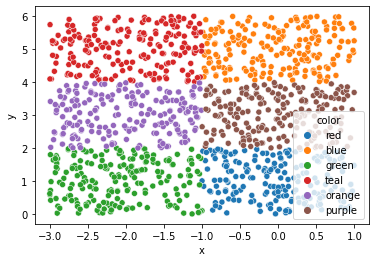

In [52]:
test.plot()

In [57]:
colors_dict = dict([(key, value) for (key, value) in enumerate(['red', 'blue', 'green', 'teal', 'orange', 'purple'])])
colors_dict

{0: 'red', 1: 'blue', 2: 'green', 3: 'teal', 4: 'orange', 5: 'purple'}

In [67]:
index = torch.argmax(net(torch.Tensor([-3.0, 2.0])))
colors_dict[index.item()]

'green'